In [87]:
!pip install langchain-groq

In [223]:
groq_api_key = "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"

In [224]:
from langchain_groq import ChatGroq

llama3 = ChatGroq(api_key=groq_api_key, model="mixtral-8x7b-32768")

llama3

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7be3a0f2a830>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7be3a0f2acb0>, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [145]:
llama3.invoke("Hello, How are you?")

AIMessage(content="As an AI, I don't have feelings, but I'm ready to assist you! How can I help you today?\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 15, 'total_tokens': 45, 'completion_time': 0.054545455, 'prompt_time': 0.0001047, 'queue_time': 0.013552079000000002, 'total_time': 0.054650155}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d632ceaf-4b4d-4369-857a-ce230845faac-0', usage_metadata={'input_tokens': 15, 'output_tokens': 30, 'total_tokens': 45})

In [91]:
!pip install pdfminer.six

In [92]:
!pip install langchain

In [93]:

# Imports
from langchain_groq import ChatGroq
from langchain import PromptTemplate, LLMChain
from langchain.llms.base import LLM
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, PrivateAttr
from typing import List, Optional, Mapping, Any
from pdfminer.high_level import extract_text
import glob
import os
import json
import pandas as pd
import matplotlib.pyplot as plt



# Corrected GroqLLM class
class GroqLLM(LLM):
    api_key: str
    model_name: str
    _chatgroq: ChatGroq = PrivateAttr()

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self._chatgroq = ChatGroq(api_key=self.api_key, model=self.model_name)

    @property
    def _llm_type(self) -> str:
        return "groq_llm"

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        response = self._chatgroq.invoke(prompt)
        return response

    @property
    def _identifying_params(self) -> Mapping[str, Any]:
        return {"model_name": self.model_name}

# Initialize the LLM
llm = GroqLLM(api_key=groq_api_key, model_name="llama-3.2-90b-vision-preview")




In [219]:
# Define the Pydantic model
class FinancialData(BaseModel):
    company_name: str
    revenue_forecast: Optional[float] = None
    capex_forecast: Optional[float] = None
    margin_forecast: Optional[float] = None

# Create the output parser
output_parser = PydanticOutputParser(pydantic_object=FinancialData)

template = """
As an AI assistant, extract the following financial metrics from the provided company document text:

- **Company Name**
- **Revenue forecasted for next year expected is also fine** (numeric value only)
- **CAPEX forecasted for next year,this is capital expenditure,expected or average aso fine** (numeric value only)
- **Margin forecasted for next year also called as EBIDTA Margin expected or average also fine** (numeric value only)

If data for the **next year** is not explicitly stated, use any value stated for the **near future**. only numeric values

Provide the extracted information in the following JSON format:

{{
    "company_name": "Company Name",
    "revenue_forecast": Numeric Value ,
    "capex_forecast": Numeric Value ,
    "margin_forecast": Numeric Value
}}



Here is the company document text:

\"\"\"
{text}
\"\"\"
"""

prompt = PromptTemplate(
    input_variables=["text"],
    partial_variables={"format_instructions": ""},
    template=template
)

# Create the LLMChain
llm_chain = LLMChain(prompt=prompt, llm=llama3)



In [210]:
def validate_and_clean_data(data: FinancialData) -> FinancialData:
    """
    Validates and cleans extracted data. Converts "null" or invalid entries to None.
    Ensures all forecasts are numeric or None.
    """
    # Convert "null" strings to None and ensure numbers are valid
    def safe_convert(value):
        if value in ["null", None]:
            return None
        try:
            return float(value)
        except ValueError:
            return None

    return FinancialData(
        company_name=data.company_name,
        revenue_forecast=safe_convert(data.revenue_forecast),
        capex_forecast=safe_convert(data.capex_forecast),
        margin_forecast=safe_convert(data.margin_forecast)
    )


In [211]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [212]:


# Function to extract text from PDF using pdfminer
def extract_text_from_pdf(pdf_path):
    text = extract_text(pdf_path)
    return text

# Get all PDF files
pdf_files = glob.glob('/content/*.pdf')


In [213]:
capex_current_data = {
    "ZENTECH": 93,
    "TITAN": 3709,
    "PGEL": 783,
    "KLBRN": 100,
    "HAL": 7950,
    "BRITANNIA": 2890
}
revenue_current_data = {
    "ZENTECH": 440,
    "TITAN": 51084,
    "PGEL": 2746,
    "KLBRN": 293,
    "HAL": 30381,
    "BRITANNIA": 16769
}

margin_current_data = {
    "ZENTECH": 41,
    "TITAN": 10,
    "PGEL": 10,
    "KLBRN": 22,
    "HAL": 32,
    "BRITANNIA": 19
}

pat_current_data = {
    "ZENTECH": 130,
    "TITAN": 3496,
    "PGEL": 135,
    "KLBRN": 40,
    "HAL": 6600,
    "BRITANNIA": 2134
}


In [214]:
import re

def parse_numeric_value(value):
    """
    Parses a numeric string and converts it to a float.
    Handles commas, currency symbols, and percentage signs.
    Returns None if the value cannot be converted.
    """
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return value
    try:
        # Remove commas, currency symbols, and percentage signs
        value_cleaned = re.sub(r'[,\$%]', '', value)
        # Convert to float
        return float(value_cleaned)
    except ValueError:
        return None


In [215]:
def compute_forecasted_pat(data, pat_current, revenue_current, margin_current, capex_current):
    forecasted_pats = []

    # Ensure current values are floats
    pat_current = float(pat_current)
    revenue_current = float(revenue_current)
    margin_current = float(margin_current)
    capex_current = float(capex_current)

    # Based on Revenue
    for rev_proj in data.revenue_projections:
        revenue_forecasted = parse_numeric_value(rev_proj.get('amount'))
        if revenue_forecasted and revenue_current:
            pat = pat_current * (revenue_forecasted / revenue_current) ** 1.5
            forecasted_pats.append(('Revenue', rev_proj.get('year'), pat))

    # Based on Margin
    for margin_proj in data.margin_targets:
        margin_forecasted = parse_numeric_value(margin_proj.get('percentage'))
        if margin_forecasted and margin_current:
            pat = pat_current * (margin_forecasted / margin_current) ** 1.2
            forecasted_pats.append(('Margin', margin_proj.get('year'), pat))

    # Based on Capex
    for capex_proj in data.CAPEX_data:
        capex_forecasted = parse_numeric_value(capex_proj.get('amount'))
        if capex_forecasted and capex_current:
            pat = pat_current * (capex_forecasted / capex_current) ** 1.5
            forecasted_pats.append(('Capex', capex_proj.get('year'), pat))

    return forecasted_pats


In [216]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [217]:
# Define the maximum tokens per chunk (adjust as needed)
max_tokens = 6000  # Adjust based on the model's limit and prompt size

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=max_tokens,
    chunk_overlap=200,  # Overlap between chunks to maintain context
    separators=["\n\n", "\n", " ", ""]
)


In [220]:
# Initialize the list to store all forecasted PATs and associated forecast data
all_forecasted_pats = []

for pdf_file in pdf_files:
    company_name = os.path.basename(pdf_file).replace('.pdf', '')
    text = extract_text_from_pdf(pdf_file)

    # Split the text into chunks if necessary
    text_chunks = text_splitter.split_text(text)

    # Initialize variables to collect extracted data
    data_collected = False
    combined_data = None

    # Process each chunk until we get valid data
    for chunk in text_chunks:
        # Run the LLMChain on the chunk
        output = llm_chain.run(text=chunk)

        # Parse the output
        try:
            # Parse JSON output into FinancialData model
            data = output_parser.parse(output)
            # Validate and clean the data to ensure proper format
            cleaned_data = validate_and_clean_data(data)

            # Check if any forecasts are available
            if cleaned_data.revenue_forecast or cleaned_data.capex_forecast or cleaned_data.margin_forecast:
                combined_data = cleaned_data
                data_collected = True
                break  # Exit loop once valid data is collected
        except Exception as e:
            print(f"Error parsing output for {company_name} in chunk: {e}")
            continue

    if not data_collected:
        print(f"No forecast data extracted for {company_name}")
        continue

    # Prepare to store detailed PAT calculations
    company_forecasts = {
        "company_name": company_name,
        "forecasts": [],
        "retrieved_data": {
            "revenue_forecasted": combined_data.revenue_forecast,
            "margin_forecasted": combined_data.margin_forecast,
            "capex_forecasted": combined_data.capex_forecast,
        }
    }

    # Compute forecasted PAT based on available data
    # Store each type of forecasted PAT with associated method and year
    forecasted_pats = []

    # Based on Revenue
    if combined_data.revenue_forecast:
        revenue_forecasted = combined_data.revenue_forecast
        if revenue_forecasted and revenue_current:
            pat = pat_current * (revenue_forecasted / revenue_current) ** 1.5
            forecasted_pats.append(("Revenue", "Next Year", pat))

    # Based on Margin
    if combined_data.margin_forecast:
        margin_forecasted = combined_data.margin_forecast
        if margin_forecasted and margin_current:
            pat = pat_current * (margin_forecasted / margin_current) ** 1.2
            forecasted_pats.append(("Margin", "Next Year", pat))

    # Based on Capex
    if combined_data.capex_forecast:
        capex_forecasted = combined_data.capex_forecast
        if capex_forecasted and capex_current:
            pat = pat_current * (capex_forecasted / capex_current) ** 1.5
            forecasted_pats.append(("Capex", "Next Year", pat))

    # Append all forecasted PAT calculations to the company's forecast data
    for method, year, pat_value in forecasted_pats:
        company_forecasts["forecasts"].append({
            "method": method,
            "year": year,
            "forecasted_pat": pat_value
        })

    # Add company forecast details to the main list
    all_forecasted_pats.append(company_forecasts)

# Now all_forecasted_pats contains all forecasted PATs and original data for each company


Error parsing output for BRITANNIA in chunk: Invalid json output: Based on the provided document, here are the financial metrics for the near future:

{
    "company_name": "Britannia Industries Limited",
    "revenue_forecast": 4130,
    "capex_forecast": null,
    "margin_forecast": 16.5
}

Please note that the revenue forecast is actually a historical value for Q1 FY'25 (which is for the period ending 30th June, 2024). The document does not provide explicit forecasted values for the next year or the near future for CAPEX and EBIDTA margin. Therefore, I provided the most recent available values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/OUTPUT_PARSING_FAILURE
Error parsing output for BRITANNIA in chunk: Invalid json output: Based on the provided document, here is the financial information I was able to extract:

{
    "company_name": "Britannia Industries Limited",
    "revenue_forecast": null,
    "capex_forecast": null,
    "margin_forecas

In [221]:
print(all_forecasted_pats)

[{'company_name': 'BRITANNIA', 'forecasts': [{'method': 'Revenue', 'year': 'Next Year', 'forecasted_pat': 3738.4313938449804}, {'method': 'Margin', 'year': 'Next Year', 'forecasted_pat': 30.35529942061864}], 'retrieved_data': {'revenue_forecasted': 4130.0, 'margin_forecasted': 12.2, 'capex_forecasted': None}}, {'company_name': 'TITAN', 'forecasts': [{'method': 'Margin', 'year': 'Next Year', 'forecasted_pat': 23.91127444970898}], 'retrieved_data': {'revenue_forecasted': None, 'margin_forecasted': 10.0, 'capex_forecasted': None}}, {'company_name': 'KLBRN', 'forecasts': [{'method': 'Revenue', 'year': 'Next Year', 'forecasted_pat': 157.4778018535759}, {'method': 'Capex', 'year': 'Next Year', 'forecasted_pat': 14.957291261782919}], 'retrieved_data': {'revenue_forecasted': 500.0, 'margin_forecasted': None, 'capex_forecasted': 22.0}}, {'company_name': 'ZENTECH', 'forecasts': [{'method': 'Revenue', 'year': 'Next Year', 'forecasted_pat': 380.30155548318515}, {'method': 'Margin', 'year': 'Next Y

In [222]:
import pandas as pd

# Convert all_forecasted_pats to a list of flattened dictionaries for each forecast entry
data_for_df = []
for company_data in all_forecasted_pats:
    company_name = company_data["company_name"]
    retrieved_data = company_data["retrieved_data"]

    # Loop over each forecast in the company's forecasts
    for forecast in company_data["forecasts"]:
        # Create a dictionary for each forecast entry
        entry = {
            "company_name": company_name,
            "revenue_forecasted": retrieved_data.get("revenue_forecasted"),
            "margin_forecasted": retrieved_data.get("margin_forecasted"),
            "capex_forecasted": retrieved_data.get("capex_forecasted"),
            "method": forecast["method"],
            "year": forecast["year"],
            "forecasted_pat": forecast["forecasted_pat"]
        }
        data_for_df.append(entry)

# Create a DataFrame from the list of dictionaries
df_forecasted_pats = pd.DataFrame(data_for_df)

# Save the DataFrame to a CSV file
df_forecasted_pats.to_csv("forecasted_pats.csv", index=False)

print("Data saved to forecasted_pats.csv")


Data saved to forecasted_pats.csv


In [245]:
csv_file_path = '/content/forecasted_pats.csv'

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
df.head()

,COMPANY NAME,REVENUE_2025,EBITA_MARGIN,CAPEX,PAT
0,Zen Technologies,500,22,130,130
1,Titan,3650,15,1163,3496
2,PG Electroplast,35000,35,10950,135
3,Kilburn Engineering,70000,12,4509,40
4,Hindustan Aeronautics,900,35,105,6600


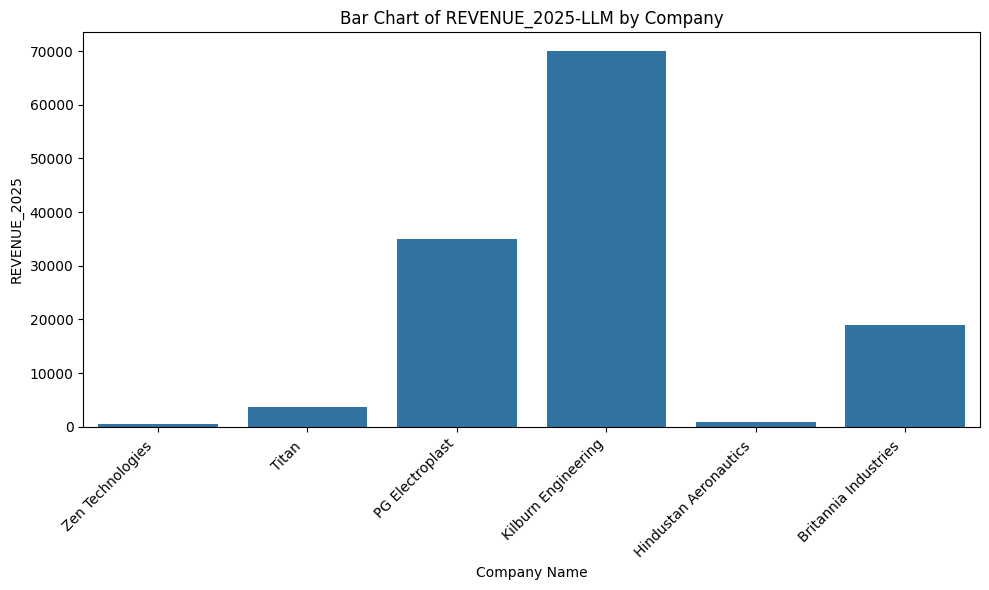

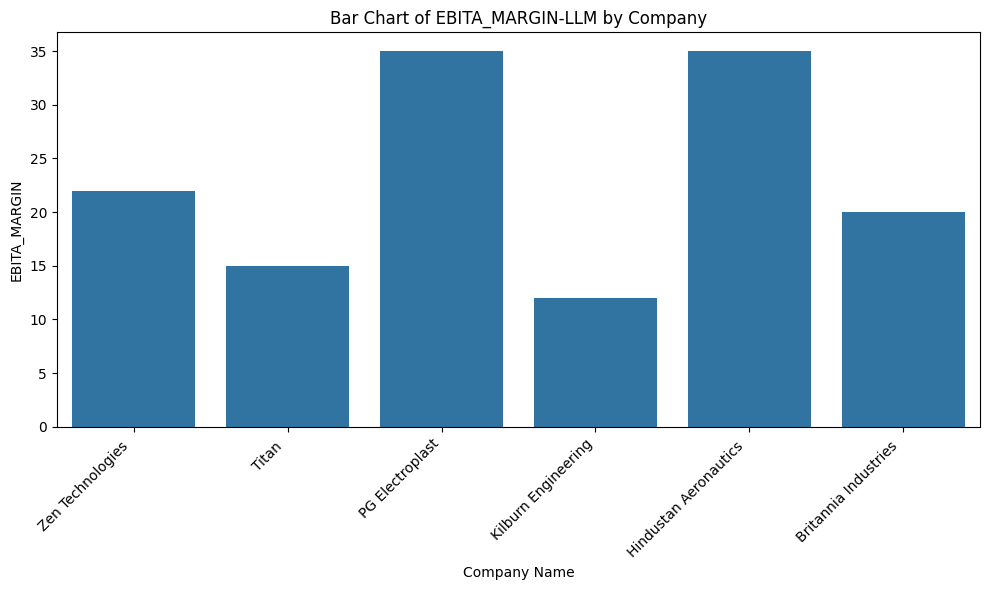

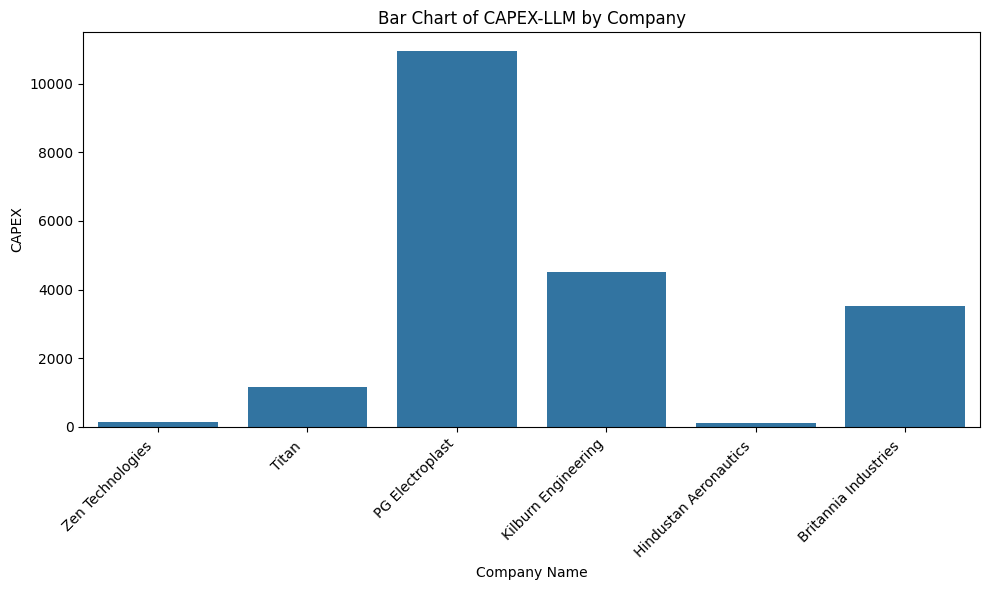

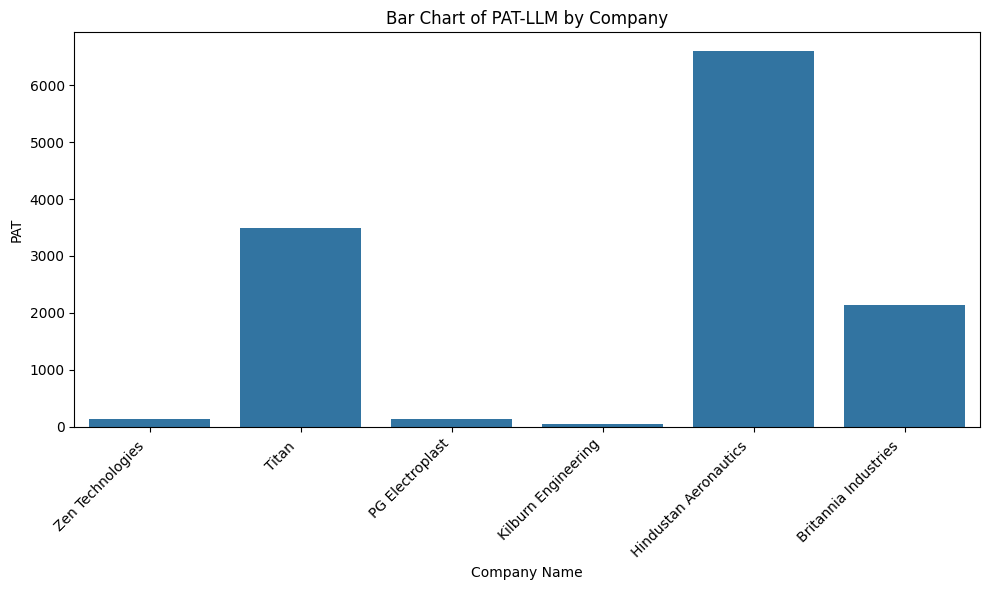

In [254]:


import matplotlib.pyplot as plt
import seaborn as sns

# List of features to plot
features = ['REVENUE_2025', 'EBITA_MARGIN', 'CAPEX', 'PAT']

# Create a bar chart for each feature
for feature in features:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.barplot(x='COMPANY NAME', y=feature, data=df)
    plt.title(f'Bar Chart of {feature}-LLM by Company')
    plt.xlabel('Company Name')
    plt.ylabel(feature)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()


In [248]:
csv_file_path = '/content/Level1_expected_data.csv'

# Load the CSV file
df2 = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
df2.head()

,STOCK_TICKER,REVENUE_2025,EBITA_MARGIN,CAPEX
0,KILBURN,500,22,130
1,PGEL,3650,15,1163
2,HAL,35000,35,10950
3,TITAN,70000,12,4509
4,ZENTEC,900,35,93


<Figure size 1000x600 with 0 Axes>

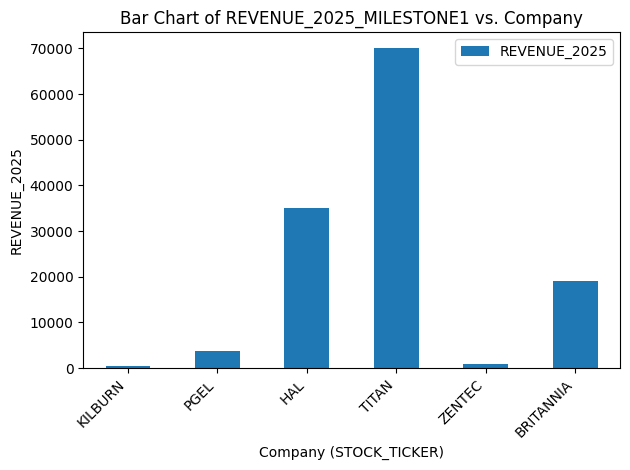

<Figure size 1000x600 with 0 Axes>

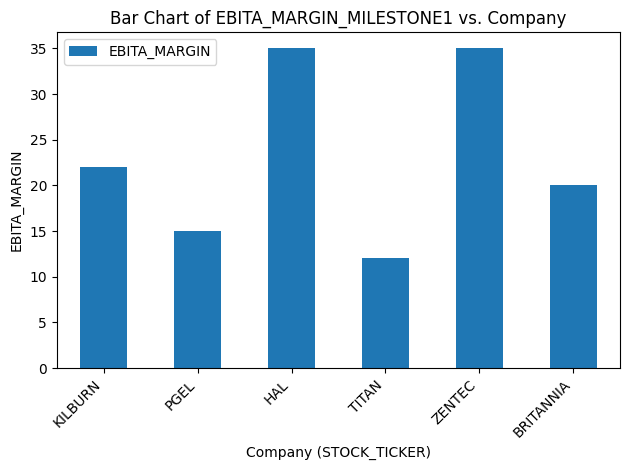

<Figure size 1000x600 with 0 Axes>

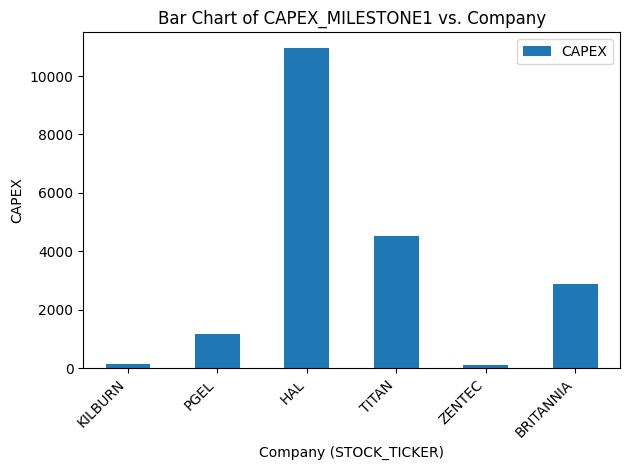

In [255]:


import pandas as pd
import matplotlib.pyplot as plt



# List of features to plot
features = ['REVENUE_2025', 'EBITA_MARGIN', 'CAPEX']

for feature in features:
    plt.figure(figsize=(10, 6))
    df2.plot(x='STOCK_TICKER', y=feature, kind='bar')
    plt.title(f'Bar Chart of {feature}_MILESTONE1 vs. Company')
    plt.xlabel('Company (STOCK_TICKER)')
    plt.ylabel(feature)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

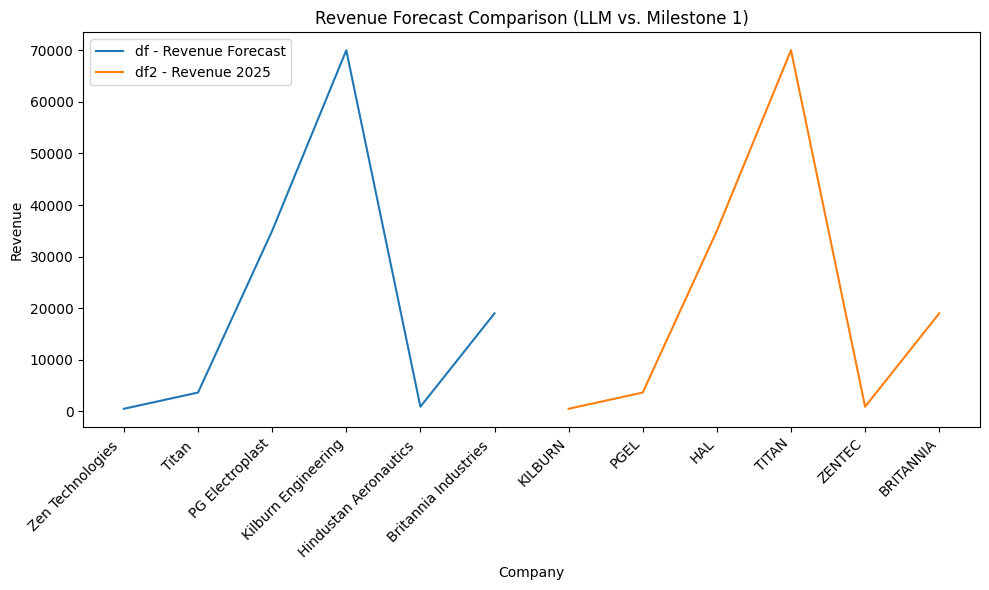

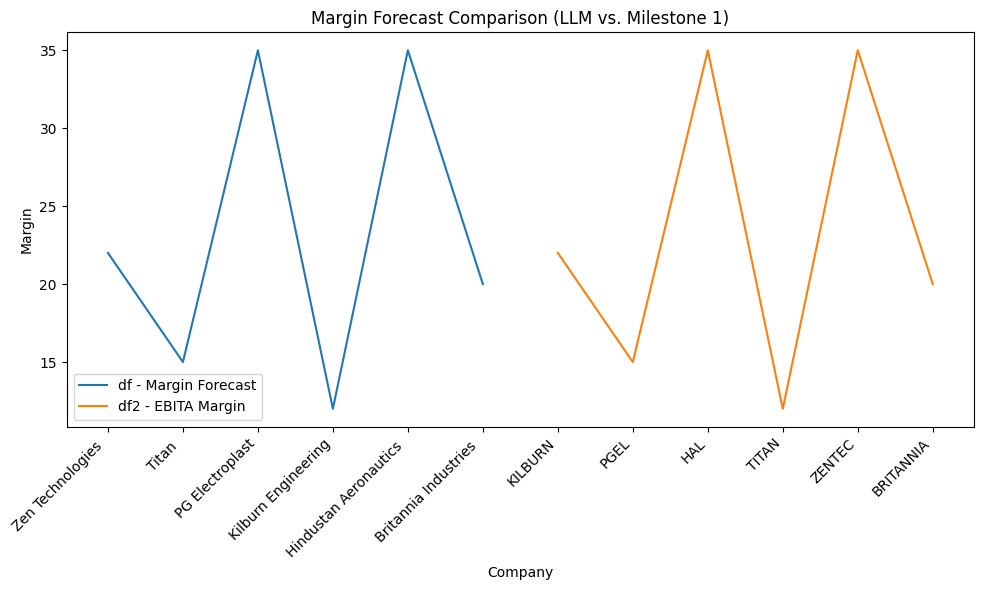

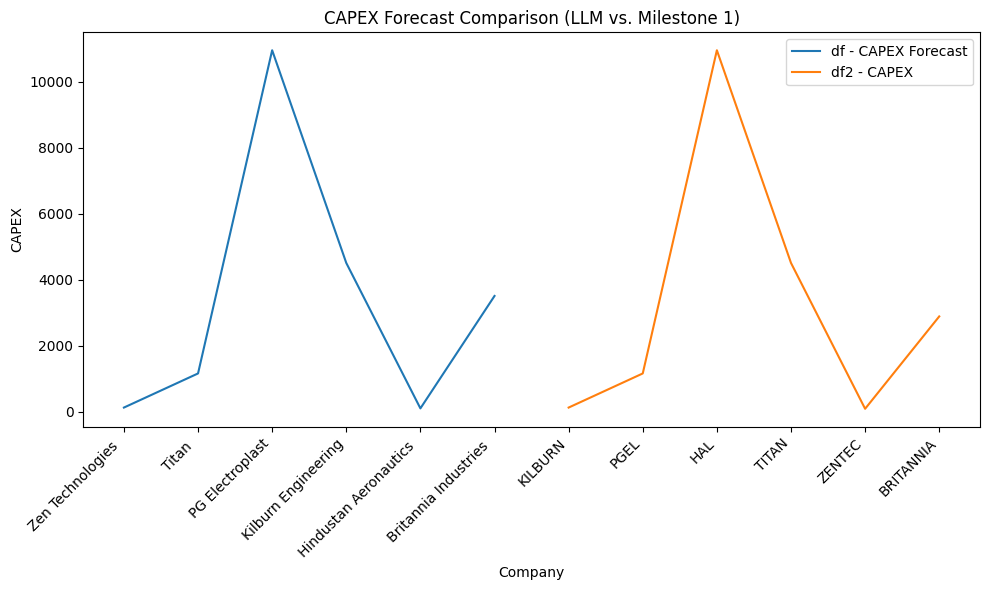

In [253]:
import matplotlib.pyplot as plt

# 1. Plot revenue_forecasted from df against REVENUE_2025 from df2
plt.figure(figsize=(10, 6))
plt.plot(df['COMPANY NAME'], df['REVENUE_2025'], label='df - Revenue Forecast')
plt.plot(df2['STOCK_TICKER'], df2['REVENUE_2025'], label='df2 - Revenue 2025')
plt.xlabel("Company")
plt.ylabel("Revenue")
plt.title("Revenue Forecast Comparison (LLM vs. Milestone 1)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


# 2. Plot margin_forecasted from df against EBITA_MARGIN from df2
plt.figure(figsize=(10, 6))
plt.plot(df['COMPANY NAME'], df['EBITA_MARGIN'], label='df - Margin Forecast')
plt.plot(df2['STOCK_TICKER'], df2['EBITA_MARGIN'], label='df2 - EBITA Margin')
plt.xlabel("Company")
plt.ylabel("Margin")
plt.title("Margin Forecast Comparison (LLM vs. Milestone 1)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


# 3. Plot capex_forecasted from df against CAPEX from df2
plt.figure(figsize=(10, 6))
plt.plot(df['COMPANY NAME'], df['CAPEX'], label='df - CAPEX Forecast')
plt.plot(df2['STOCK_TICKER'], df2['CAPEX'], label='df2 - CAPEX')
plt.xlabel("Company")
plt.ylabel("CAPEX")
plt.title("CAPEX Forecast Comparison (LLM vs. Milestone 1)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()